In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
#import mpld3
#mpld3.enable_notebook()
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_absolute_error



In [2]:
def read_json(name):
    with open(name) as data_file:    
            data = json.load(data_file)
    return data

In [3]:
def data_proces(name,Deface=100,NumSam=200):
    datos=read_json(name)
    entradas=read_json('_'.join(('inp',name)))
    train=np.array([[0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0]])
    referencia=[0]
    for key in datos.keys():
        #print(datos[key][1].keys())
        #print(len(datos[key]))
        for k,exp in enumerate(datos[key]):
            #print(k)
            #v_t_1=exp["velocity"][Deface-1]*0.01
            #v_t_2=exp["velocity"][Deface-2]*0.01
            #v_t_3=exp["velocity"][Deface-3]*0.01
            #D_t_1=exp["displace"][Deface-1]
            #D_t_2=exp["displace"][Deface-2]
            #D_t_3=exp["displace"][Deface-3]
            VelC=exp["velocity"]
            forceC=exp["force"]
            VelCj=[round(elem, 1) for elem in VelC]
            Conj=set(VelCj)
            infbar=100
            for elem in list(Conj):
                indices=[i for i,x in enumerate(VelCj) if x==elem]
                #print(len(indices))
                for ind in range(len(indices)-1):
                    if forceC[indices[ind]] == forceC[indices[ind+1]] and indices[ind]> 120:
                        reference = [indices[ind],indices[ind+1]]
                        break
                    elif abs(forceC[indices[ind]]-forceC[indices[ind+1]])<infbar and indices[ind+1]-indices[ind]>20 and indices[ind+1]-indices[ind]<200 and indices[ind]> 120:
                        tempref = [indices[ind],indices[ind+1]]
                        infbar = abs(forceC[indices[ind]]-forceC[indices[ind+1]])
                if 'reference' in locals():
                    break
            
            if 'reference' in locals():    
                Deface = reference[0]
                NumSam = reference[1] - reference[0]
                del reference
            else:
                Deface = tempref[0]
                NumSam = tempref[1] - tempref[0]
                #print(tempref)
                del tempref
            referencia.append(referencia[-1]+NumSam+1)
            #print(NumSam+1)
            #print(key)
            #print(Deface)
            #print(NumSam)
            for element in range(NumSam+1):
                caso=list()
                caso.append(entradas[key]["Ap"])
                caso.append(entradas[key]["Ag"])
                caso.append(entradas[key]["h"])
                caso.append(entradas[key]["L"])
                caso.append(entradas[key]["viscocidad"])
                caso.append(entradas[key]["Ty"][k]/1000)
                caso.append((exp["velocity"][element+Deface])*0.001)
                caso.append(exp["displace"][element+Deface])
                #caso.append(v_t_1)
                #caso.append(D_t_1)
                #caso.append(v_t_2)
                #caso.append(D_t_2)
                #caso.append(v_t_3)
                #caso.append(D_t_3)
                #v_t_1=(exp["velocity"][element+Deface])*0.01
                #v_t_2=(exp["velocity"][element+Deface-1])*0.01
                #v_t_3=(exp["velocity"][element+Deface-2])*0.01
                #D_t_1=exp["displace"][element+Deface]
                #D_t_2=exp["displace"][element+Deface-1]
                #D_t_3=exp["displace"][element+Deface-2]
                caso.append(exp["force"][element+Deface])
                c=Target_C(caso)
                #fr=force_limit(caso)
                caso.append(c)
                casonp=np.array(caso)
                #print(casonp.shape)
                train=np.append(train,[casonp],axis=0)
            
    return train[2:][:],referencia

In [4]:
def Target_C(data):
    Arn=(data[0]+((data[1])/2))
    Fn=((12*(data[4])*Arn*(data[6]/10))/((data[1])*data[2]*data[2]))
    Fn=Fn*(data[0]*data[3])
    Fty=data[8]-Fn
    c=((Fty*data[2])/(data[3]*data[0]*data[5]*1000))
    return Fty

In [5]:
def force_limit(data):
    Arn=(data[0]+((data[1])/2))
    Fn=((12*(data[4])*Arn*(data[6]))/((data[1])*data[2]*data[2]))
    Fn=Fn*(data[0]*data[3])
    #c=2.07+((12*data[4]*data[0]*data[6])/((12*data[4]*data[0]*data[6])+(0.4*data[1]*data[2]*data[5])))
    c=1.07
    Fty= (c*data[3]*data[0]*data[5]*1000)/(data[2])
    fr=Fn+Fty
    #print(fr)
    #print(data[8])
    return fr

In [6]:
train,refer=data_proces("twofluidexp.json",Deface=120,NumSam=260)
#print(train.shape)
#print(train[1:4])
np.random.shuffle(train)
#train[1:4,8:9].shape
#print(train[20][])
#print(refer)

In [7]:
def Error_test(Salidas,Fuerza):
    errores=[]
    maximo=[]
    minimo=[]
    for caso in range(len(Salidas)):
        errores.append(mean_absolute_error(Salidas[caso],Fuerza[caso]))
        maximo.append(max(abs(Salidas[caso]-Fuerza[caso])))
        minimo.append(min(abs(Salidas[caso]-Fuerza[caso])))
    return sum(errores)/len(errores), max(maximo),min(minimo)
        

In [8]:
def Deep_neural_network(
    learning_rate = 1e-2,
    batch_size=20,
    Drop_prob=1.0,
    n_nodes_hl1 = 30,
    n_nodes_hl2 = 30,
    n_nodes_hl3 = 30,
    n_nodes_hl4 = 30,
    n_classes=1):
    
    
    
    #input place holder 
    x= tf.placeholder(tf.float32,[batch_size,8], name='input_placeholder')
    #output place holder
    y =tf.placeholder(tf.float32,[batch_size,1],name='output_placeholder')
    
    hidden_1_layer = {'weights':tf.Variable(tf.random_normal([8, n_nodes_hl1])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}

    hidden_3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl3]))}
    
    hidden_4_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3, n_nodes_hl4])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl4]))}
    


    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                    'biases':tf.Variable(tf.random_normal([n_classes])),}
    
    l1 = tf.add(tf.matmul(x,hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)
    l1 = tf.nn.dropout(l1,Drop_prob)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)
    l2 = tf.nn.dropout(l2,Drop_prob)

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)
    l3 = tf.nn.dropout(l3,Drop_prob)
    
    l4 = tf.add(tf.matmul(l3,hidden_4_layer['weights']), hidden_4_layer['biases'])
    l4 = tf.nn.relu(l4)
    l4 = tf.nn.dropout(l4,Drop_prob)
    
    #l5 = tf.add(tf.matmul(l4,hidden_5_layer['weights']), hidden_5_layer['biases'])
    #l5 = tf.nn.relu(l5)
    #l5 = tf.nn.dropout(l5,Drop_prob)

    output = tf.matmul(l3,output_layer['weights']) + output_layer['biases']
    
    #total_loss = tf.losses.mean_squared_error(output, y)
   
    #train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    
    
    return dict(
        x = x,
        y = y,
        output=output,
        #total_loss = total_loss,
        #train_step = train_step,
        saver = tf.train.Saver() 
    )
    
            

In [9]:
def check_net(g, checkpoint,test_X ):
    """ Accepts a current character, initial state"""

    with tf.Session() as sess:
        #sess.run(tf.initialize_all_variables())
        g['saver'].restore(sess, checkpoint)
        num,ad=test_X.shape
        encodings=[]
        for i in range(num):
            feed_dict={g['x']: [test_X[i,0:8]],g['y']: [test_X[i,8:9]]}
           

            preds = sess.run([g['output']], feed_dict)
            encodings.append(preds[0][0][0])
    return encodings

In [10]:
def exp_validation(name,savename,Deface=100,NumSam=200):
    pldata,ref=data_proces(name,Deface,NumSam)
    #print(ref)
    salidas=[]
    velocidad=[]
    fuerza=[]
    for limt in range(len(ref)-1):
        #plt.plot(pldata[ref[limt]:ref[limt+1],6],pldata[ref[limt]:ref[limt+1],8])
        #plt.show()
        #plt.plot(pldata[ref[limt]:ref[limt+1],6],pldata[ref[limt]:ref[limt+1],9])
        #plt.show()
        
        tf.reset_default_graph()
        g = Deep_neural_network(batch_size=1)
        #encode=check_net(g,"./ExpTrain102.ckpt",pldata[ref[limt]:ref[limt+1]])
        encode=check_net(g,savename,pldata[ref[limt]:ref[limt+1]])
        velocidad.append(pldata[ref[limt]:ref[limt+1],6])
        fuerza.append(pldata[ref[limt]:ref[limt+1],9])
        salidas.append(encode)
    return salidas,fuerza,velocidad     
   # fig = plt.figure(figsize=(10,10 ))
   # ax = fig.gca(projection='3d')
   # ax.plot(np.zeros(ref[2]-ref[1]), ,pldata[ref[1]:ref[2],9], zdir='z', label='curve in (x,y)')
   # ax.plot(np.zeros(ref[2]-ref[1]), pldata[ref[1]:ref[2],6],salidas[0], zdir='z', label='curve in (x,y)')
    
   # ax.plot(np.ones(ref[3]-ref[2])*0.25, pldata[ref[2]:ref[3],6],pldata[ref[2]:ref[3],9], zdir='z', label='curve in (x,y)')
   # ax.plot(np.ones(ref[3]-ref[2])*0.25, pldata[ref[2]:ref[3],6],salidas[1], zdir='z', label='curve in (x,y)')
    
   # ax.plot(np.ones(ref[4]-ref[3])*0.5, pldata[ref[3]:ref[4],6],pldata[ref[3]:ref[4],9], zdir='z', label='curve in (x,y)')
   # ax.plot(np.ones(ref[4]-ref[3])*0.5, pldata[ref[3]:ref[4],6],salidas[2], zdir='z', label='curve in (x,y)')
    
        #plt.plot(pldata[ref[limt]:ref[limt+1],6],pldata[ref[limt]:ref[limt+1],9])
        #plt.plot(pldata[ref[limt]:ref[limt+1],6],encode)
   # plt.show()
   # plt.tight_layout()
    
   # fig = plt.figure(figsize=(10,10 ))
   # ax = fig.gca(projection='3d')
   # ax.plot(np.zeros(ref[5]-ref[4]), pldata[ref[5]:ref[4],6],pldata[ref[5]:ref[4],9], zdir='z', label='curve in (x,y)')
   # ax.plot(np.zeros(ref[5]-ref[4]), pldata[ref[5]:ref[4],6],salidas[3], zdir='z', label='curve in (x,y)')
    
   # ax.plot(np.ones(ref[3]-ref[2])*0.25, pldata[ref[2]:ref[3],6],pldata[ref[2]:ref[3],9], zdir='z', label='curve in (x,y)')
   # ax.plot(np.ones(ref[3]-ref[2])*0.25, pldata[ref[2]:ref[3],6],salidas[2], zdir='z', label='curve in (x,y)')
    
   # ax.plot(np.ones(ref[4]-ref[3])*0.5, pldata[ref[3]:ref[4],6],pldata[ref[3]:ref[4],9], zdir='z', label='curve in (x,y)')
   # ax.plot(np.ones(ref[4]-ref[3])*0.5, pldata[ref[3]:ref[4],6],salidas[3], zdir='z', label='curve in (x,y)')
    
        #plt.plot(pldata[ref[limt]:ref[limt+1],6],pldata[ref[limt]:ref[limt+1],9])
        #plt.plot(pldata[ref[limt]:ref[limt+1],6],encode)
    # plt.show()
    # plt.tight_layout()

In [11]:
def compgraft(inxmin,inxmax,salida,vel,force,cases,labels):
    fig = plt.figure(figsize=(12,10 ))
    ax = fig.gca(projection='3d')
    for indx,inx in enumerate(range(inxmax-inxmin)):
        if indx==0:
            ax.plot(np.ones(len(salida[inx+inxmin]))*cases[inx],vel[inx+inxmin],force[inx+inxmin],zdir="z",label="Experimental",color="blue",lw=2,ls="-")
            ax.plot(np.ones(len(salida[inx+inxmin]))*cases[inx],vel[inx+inxmin],salida[inx+inxmin],zdir="z",label="DNN model",color="red",lw=2,ls="--")
        else:
            ax.plot(np.ones(len(salida[inx+inxmin]))*cases[inx],vel[inx+inxmin],force[inx+inxmin],zdir="z",color="blue",lw=2,ls="-")
            ax.plot(np.ones(len(salida[inx+inxmin]))*cases[inx],vel[inx+inxmin],salida[inx+inxmin],zdir="z",color="red",lw=2,ls="--")
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.set_title(labels[3])
    ax.legend()
    plt.show()
    #plt.tight_layout()    

In [12]:
salidas,fuerza,velocidad = exp_validation("Testcases2.json","Exp_3_30_2fluid.ckpt",Deface=120,NumSam=260)
Error_test(salidas,fuerza)

INFO:tensorflow:Restoring parameters from Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from Exp_3_30_2fluid.ckpt


(0.5386553727824507, 2.5380915745239, 4.7870729968479964e-05)

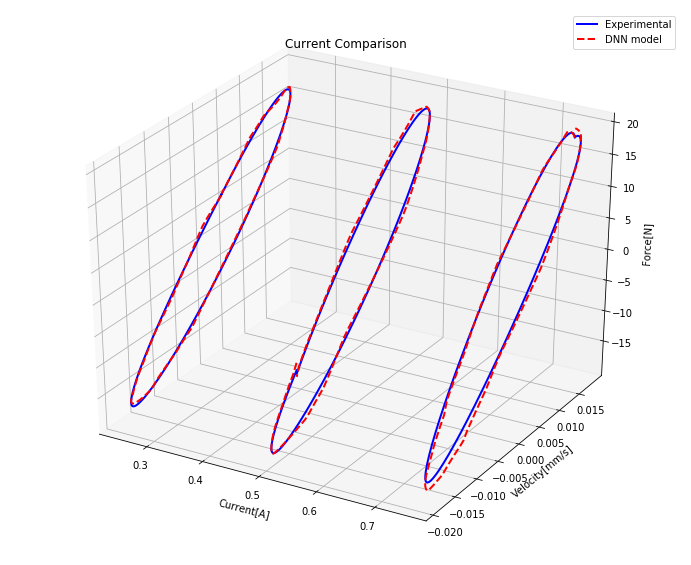

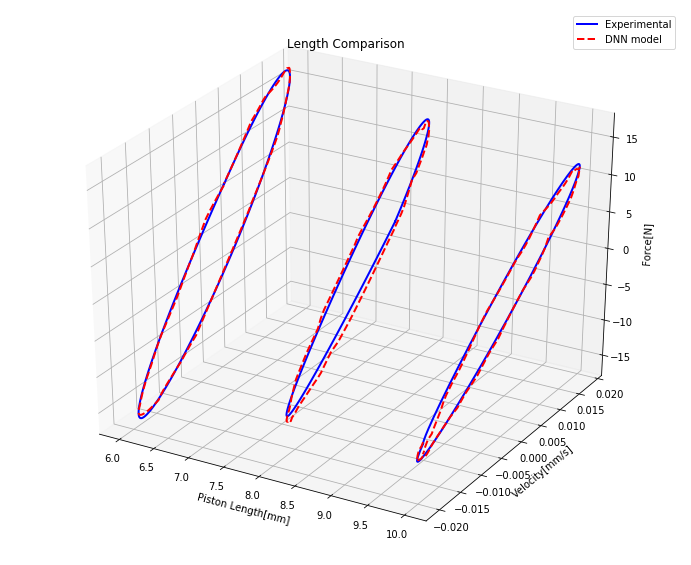

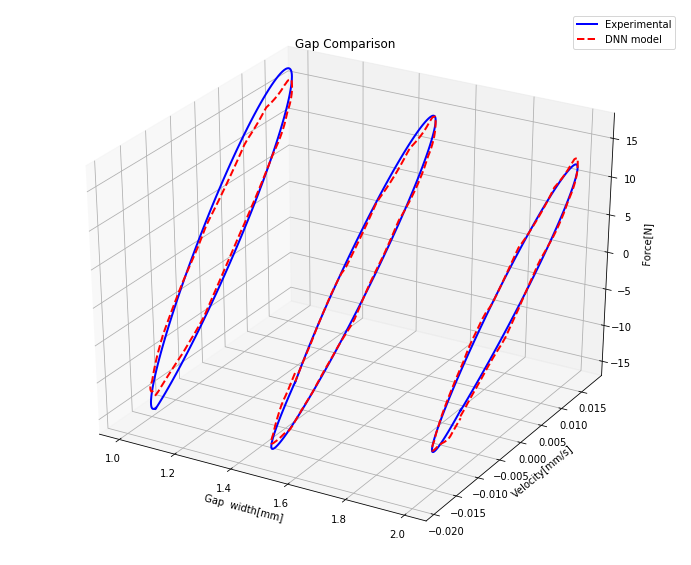

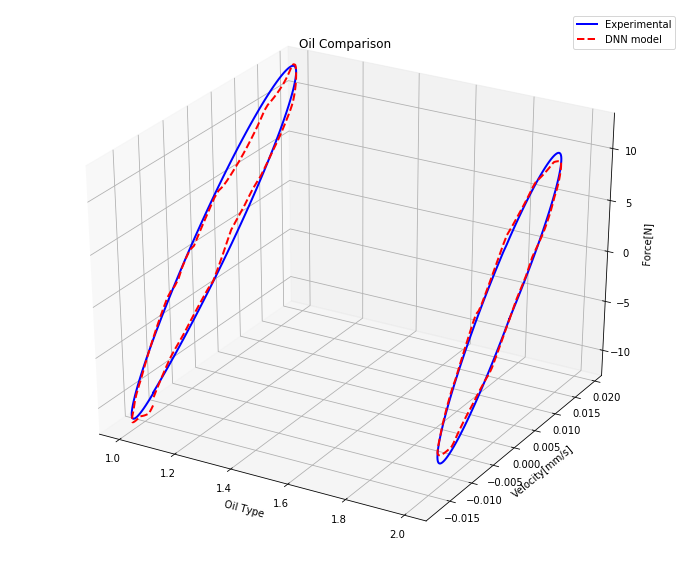

In [13]:
compgraft(0,3,salidas,velocidad,fuerza,cases=[.25,.5,.75],labels=["Current[A]","Velocity[mm/s]","Force[N]","Current Comparison"])
compgraft(3,6,salidas,velocidad,fuerza,cases=[6,8,10],labels=["Piston Length[mm]","Velocity[mm/s]","Force[N]","Length Comparison"])
compgraft(6,9,salidas,velocidad,fuerza,cases=[1,1.5,2.0],labels=["Gap  width[mm]","Velocity[mm/s]","Force[N]","Gap Comparison"])
compgraft(9,11,salidas,velocidad,fuerza,cases=[1,2,],labels=["Oil Type","Velocity[mm/s]","Force[N]","Oil Comparison"])

In [14]:
salidas,fuerza,velocidad = exp_validation("Test_experiments.json","./Exp_3_30_2fluid.ckpt",Deface=260,NumSam=400)
Error_test(salidas,fuerza)

INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring parameters from ./Exp_3_30_2fluid.ckpt
INFO:tensorflow:Restoring

(1.7077744169513271, 6.821231600116166, 0.0007337317593210102)

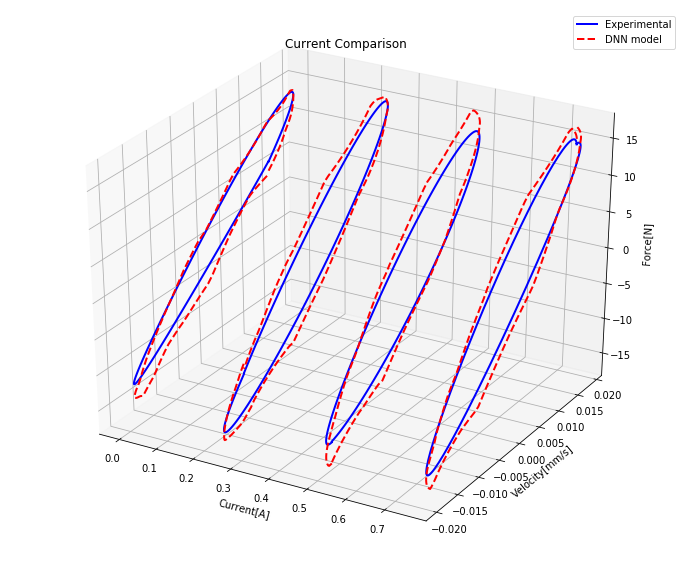

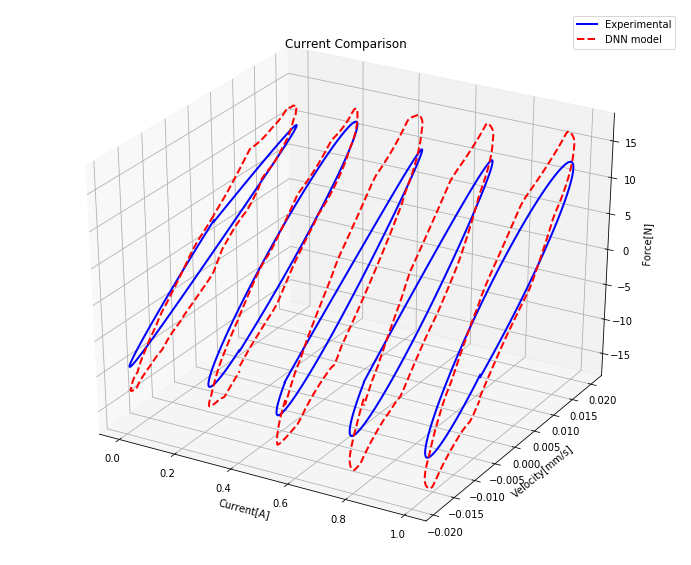

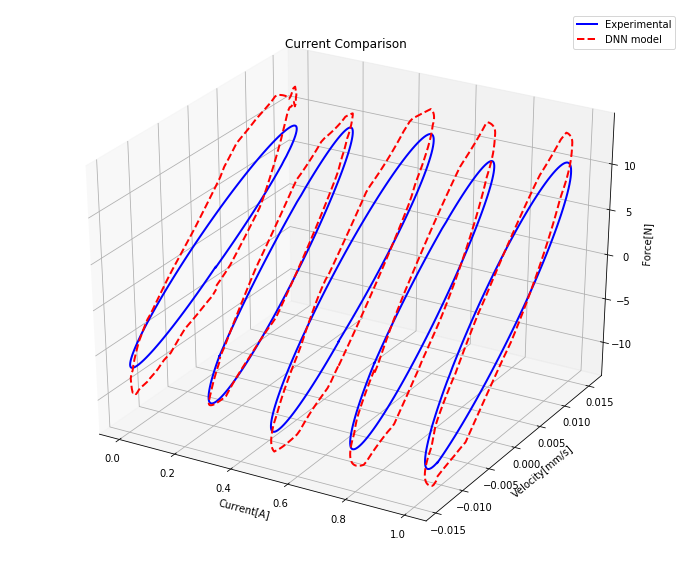

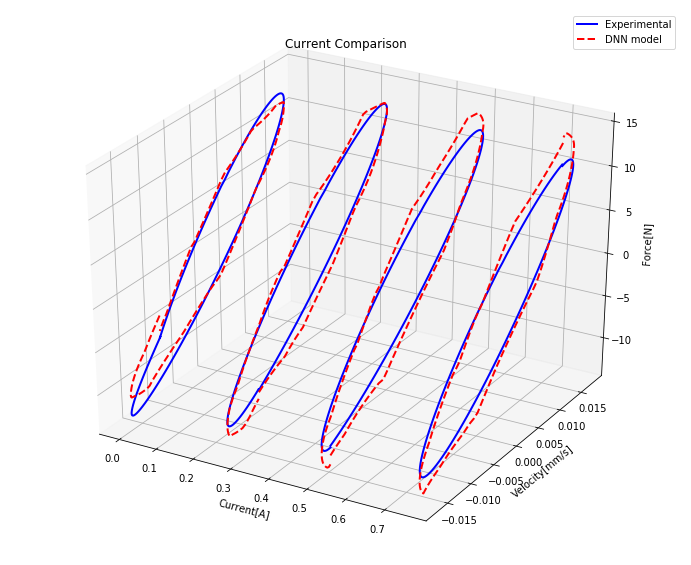

In [15]:
compgraft(1,5,salidas,velocidad,fuerza,cases=[0,.25,.5,.75,1,1.25,1.5,1.75],labels=["Current[A]","Velocity[mm/s]","Force[N]","Current Comparison"])
compgraft(6,11,salidas,velocidad,fuerza,cases=[0,.25,.5,.75,1,1.25,1.5,1.75],labels=["Current[A]","Velocity[mm/s]","Force[N]","Current Comparison"])
compgraft(12,17,salidas,velocidad,fuerza,cases=[0,.25,.5,.75,1,1.25,1.5,1.75],labels=["Current[A]","Velocity[mm/s]","Force[N]","Current Comparison"])
compgraft(19,23,salidas,velocidad,fuerza,cases=[0,.25,.5,.75,1,1.25,1.5,1.75],labels=["Current[A]","Velocity[mm/s]","Force[N]","Current Comparison"])


In [16]:
CaseDual=["h3x100","h3x30","h3x20","h3x15","h3x10","h2x100","h2x9","h1x50","h1x10"]
ErrorDual=[2.047,0.7696,0.5579,0.5115,0.9064,0.9038,1.725,1.7343,1.9978]

In [20]:
import matplotlib.pyplot as plt
plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

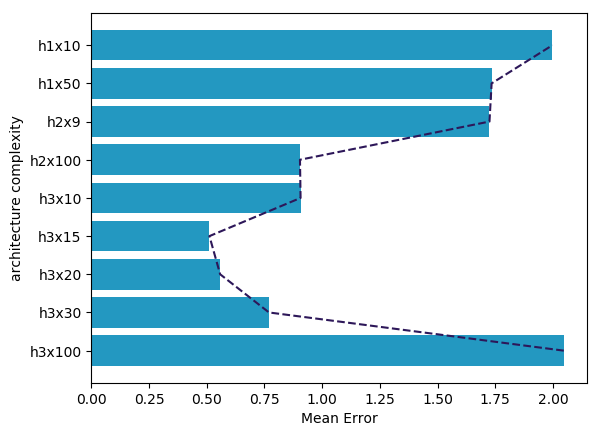

In [21]:
fig, ax = plt.subplots()
y_pos = np.arange(len(CaseDual))
ax.barh(y_pos, ErrorDual, align='center',
        color='#2398C1', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(CaseDual)
ax.set_xlabel('Mean Error')
ax.set_ylabel('architecture complexity')
ax.plot(ErrorDual, y_pos,color='#2D1759',ls='--')

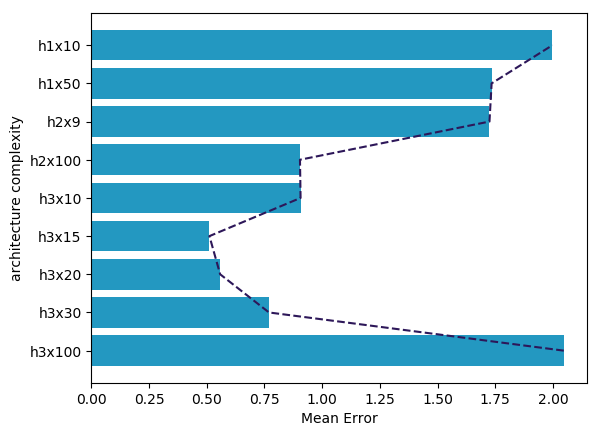

In [22]:
fig

In [25]:
CaseSingle=["h3x20","h3x10","h2x9[26]","h1x10[25]"]
ErrorDual=[0.91155,0.6126,0.5794,1.355]

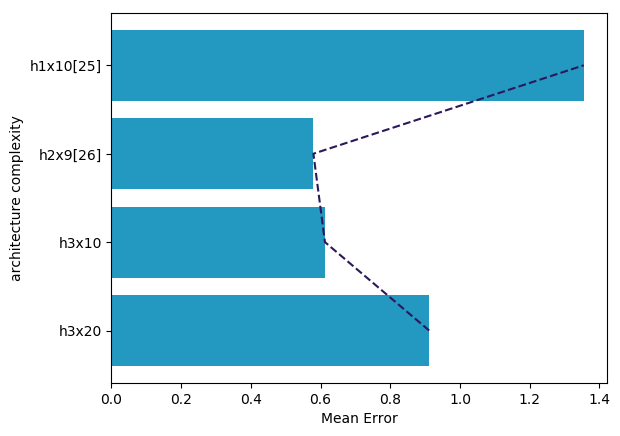

In [26]:
fig, ax = plt.subplots()
y_pos = np.arange(len(CaseSingle))
ax.barh(y_pos, ErrorDual, align='center',
        color='#2398C1', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(CaseSingle)
ax.set_xlabel('Mean Error')
ax.set_ylabel('architecture complexity')
ax.plot(ErrorDual, y_pos,color='#2D1759',ls='--')

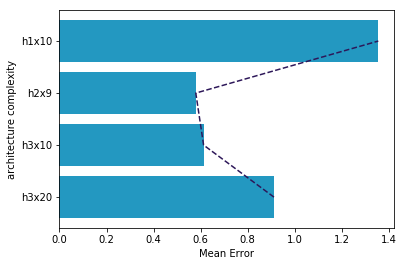

In [12]:
fig

In [41]:
ErrorGraft=read_json("twoCase_Error.json")

In [51]:
def Graficar_errores(Jason,Cases,Labels):
    fig, ax = plt.subplots()
    axes2=fig.add_axes([0.4,0.3,0.4,0.3])
    for idx,case in enumerate(Cases):
        ax.plot( np.array(Jason[case])[:,1],np.array(Jason[case])[:,2],ls='-',label=Labels[idx])
        axes2.plot( np.array(Jason[case])[:,1],np.array(Jason[case])[:,2],ls='-',label=Labels[idx])
    ax.set_xlim(0,1000)
    ax.set_ylim(0,30)
    axes2.set_xlim(600,1000)
    axes2.set_ylim(0,2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Mean Error')
    axes2.set_xlabel('Step')
    axes2.set_ylabel('Mean Error')
    ax.legend()
    
    
    plt.show()

In [52]:
np.array(ErrorGraft["3x20"])[:,2]

array([138.02850342,  98.8398056 ,  85.44141388,  61.81609344,
        45.44746017,  29.46559334,  14.21750355,  10.42707062,
         7.99043083,   8.09734821,   9.93827915,   9.87434769,
         9.37655258,  15.47442627,  10.86876202,   9.31737709,
        11.02592754,   8.04328346,   7.94933128,   7.65057325,
         7.6676898 ,   8.29440498,   8.08035088,   7.09860277,
         6.24411249,   5.8273778 ,   5.59743881,   5.72114134,
         5.51688337,   5.11256933,   5.22927904,   5.50228643,
         5.78039694,   5.44280958,   5.57323122,   5.19322395,
         4.70155811,   4.83580494,   4.83036232,   4.59506083,
         4.76192665,   6.5614934 ,   7.25309801,   7.8931036 ,
         6.83610964,   7.92614746,   6.46732903,   4.53015995,
         3.46403146,   3.66269231,   3.43850636,   3.86864805,
         3.66041231,   4.43252611,   4.3180542 ,   4.100317  ,
         3.28085446,   3.07530999,   2.81543088,   2.95459819,
         2.51499319,   2.56638885,   2.69696236,   2.41

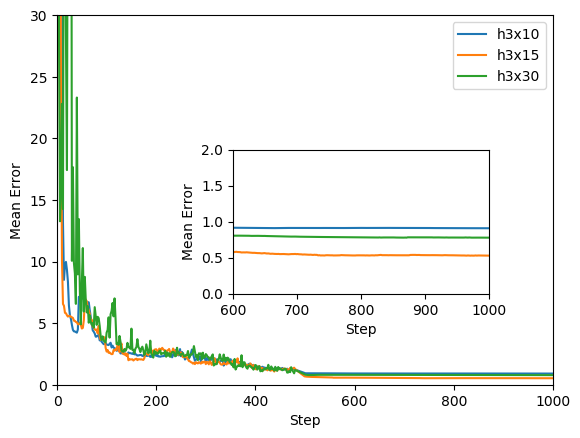

In [53]:
Graficar_errores(ErrorGraft,['3x10', '3x15', '3x30'],['h3x10', 'h3x15', 'h3x30'])

In [31]:
list(ErrorGraft.keys())

['3x20', '3x100', '2x100', '3x30', '3x10', '3x15', '1x50']

In [36]:
reg_compare=read_json("regularizationcompare.json")
list(reg_compare.keys())

['3x20', '3x20_R', 'RL_3x20_R', 'RL_3x20']

In [46]:
def Graficar_errores(Jason,Cases,Labels):
    fig, ax = plt.subplots()
    #axes2=fig.add_axes([0.4,0.3,0.4,0.3])
    for idx,case in enumerate(Cases):
        ax.plot( np.array(Jason[case])[:,1],np.array(Jason[case])[:,2],ls='-',label=Labels[idx])
        #axes2.plot( np.array(Jason[case])[:,1],np.array(Jason[case])[:,2],ls='-',label=case)
    ax.set_xlim(0,1000)
    ax.set_ylim(0,30)
    #axes2.set_xlim(600,1000)
    #axes2.set_ylim(0,2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Mean Error')
    #axes2.set_xlabel('Step')
    #axes2.set_ylabel('Mean Error')
    ax.legend()
    
    
    plt.show()

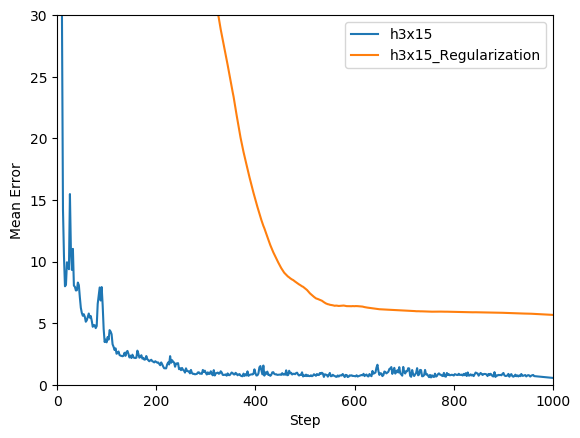

In [35]:
Graficar_errores(reg_compare,['3x20', '3x20_R'],['h3x15', 'h3x15_Regularization'])

In [38]:
def Graficar_errores(Jason,Cases,Labels):
    fig, ax = plt.subplots()
    #axes2=fig.add_axes([0.4,0.3,0.4,0.3])
    for idx,case in enumerate(Cases):
        ax.plot( np.array(Jason[case])[:,1],np.array(Jason[case])[:,2],ls='-',label=Labels[idx])
        #axes2.plot( np.array(Jason[case])[:,1],np.array(Jason[case])[:,2],ls='-',label=case)
    ax.set_xlim(0,1000)
    ax.set_ylim(0,6000)
    #axes2.set_xlim(600,1000)
    #axes2.set_ylim(0,2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Mean Error')
    #axes2.set_xlabel('Step')
    #axes2.set_ylabel('Mean Error')
    ax.legend()
    
    
    plt.show()

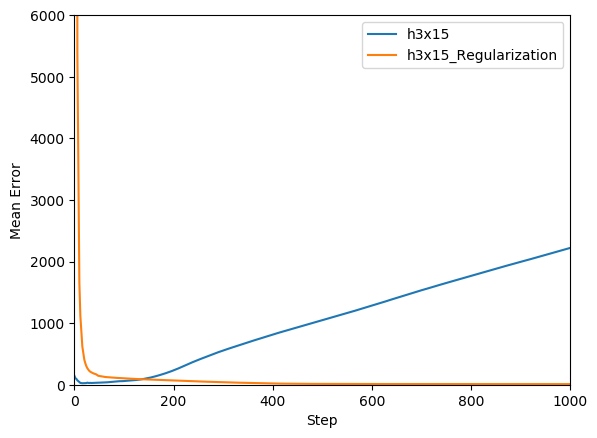

In [39]:
Graficar_errores(reg_compare,['RL_3x20', 'RL_3x20_R'],['h3x15', 'h3x15_Regularization'])